### Plotting a cycle phase of tumor's cells in time

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline
import numpy as np
from matplotlib.pyplot import figure
import numpy as np

def plot_cycle_phases(g1, s, g2m, irradiations, ylim=(0, 1)):
    figure(num=None, figsize=(15, 5), dpi=200, facecolor='w', edgecolor='k')
    plt.xticks(np.arange(0, 10.5, 1))
    plt.ylim(*ylim)
    plt.xlim(-0.1, 10.2)
    plt.grid(axis='x', linestyle='--')
    for time in irradiations:
        plt.axvline(time, color='gray')
    plt.plot(np.arange(0, 10, 1/96), g1, color='blue')
    plt.plot(np.arange(0, 10, 1/96), s, color='red')
    plt.plot(np.arange(0, 10, 1/96), g2m, color='lightgreen')

### Loading data

In [2]:
def load_timelapse(filename):
    data = np.zeros((96000, 7))
    iline = 0
    with open(filename) as file:
        for line in file:
            nums = [float(f) for f in line.split()]
            for x in range(7):
                data[iline, x] = nums[x]
            iline = iline+1
    data = data.reshape((100, 960, 7))
    for x in range(1, 4):                            
        data[:, :, x] = data[:, :, x] / data[:, :, 0]
    return data.reshape((1, 100, 960, 7))


def load_timelapse_set(filenames):
    dataset_arr = np.concatenate([load_timelapse(filename) for filename in filenames])
    dataset = {}
    dataset['total_cells'] = dataset_arr[:, :, :, 0]
    dataset['G1'] = dataset_arr[:, :, :, 1]
    dataset['S'] = dataset_arr[:, :, :, 2]
    dataset['G2M'] = dataset_arr[:, :, :, 3]
    dataset['CHO'] = dataset_arr[:, :, :, 4]
    dataset['OX'] = dataset_arr[:, :, :, 5]
    dataset['GI'] = dataset_arr[:, :, :, 6]
    return dataset # [feature][tumor, simulation, step]


b1_times = [0, 17/24, 34/24, 51/24, 68/24, 85/24, 103/24, 120/24]
b2_times = [0, 18/24, 36/24, 54/24, 72/24]

In [3]:
ref_b1 = load_timelapse_set(["timelapse-data/ref/b1/t{}.txt".format(i) for i in range(1, 11)])
ref_b1_m = {k:np.mean(v, 1) for (k, v) in ref_b1.items()}  # mean from 100 simulations 
ref_b1_m_t = {k:np.mean(v, 0) for (k, v) in ref_b1_m.items()}  # mean from 10 tumors

In [4]:
ref_b2 = load_timelapse_set(["timelapse-data/ref/b2/t{}.txt".format(i) for i in range(1, 11)])
ref_b2_m = {k:np.mean(v, 1) for (k, v) in ref_b2.items()}
ref_b2_m_t = {k:np.mean(v, 0) for (k, v) in ref_b2_m.items()}

In [5]:
gpu_b1 = load_timelapse_set(["timelapse-data/gpu/b1/t{}.txt".format(i) for i in range(1, 11)])
gpu_b1_m = {k:np.mean(v, 1) for (k, v) in gpu_b1.items()}
gpu_b1_m_t = {k:np.mean(v, 0) for (k, v) in gpu_b1_m.items()}

In [6]:
gpu_b2 = load_timelapse_set(["timelapse-data/gpu/b2/t{}.txt".format(i) for i in range(1, 11)])
gpu_b2_m = {k:np.mean(v, 1) for (k, v) in gpu_b2.items()}
gpu_b2_m_t = {k:np.mean(v, 0) for (k, v) in gpu_b2_m.items()}

# Cycle phase plots

## Benchmark 1
### Reference 

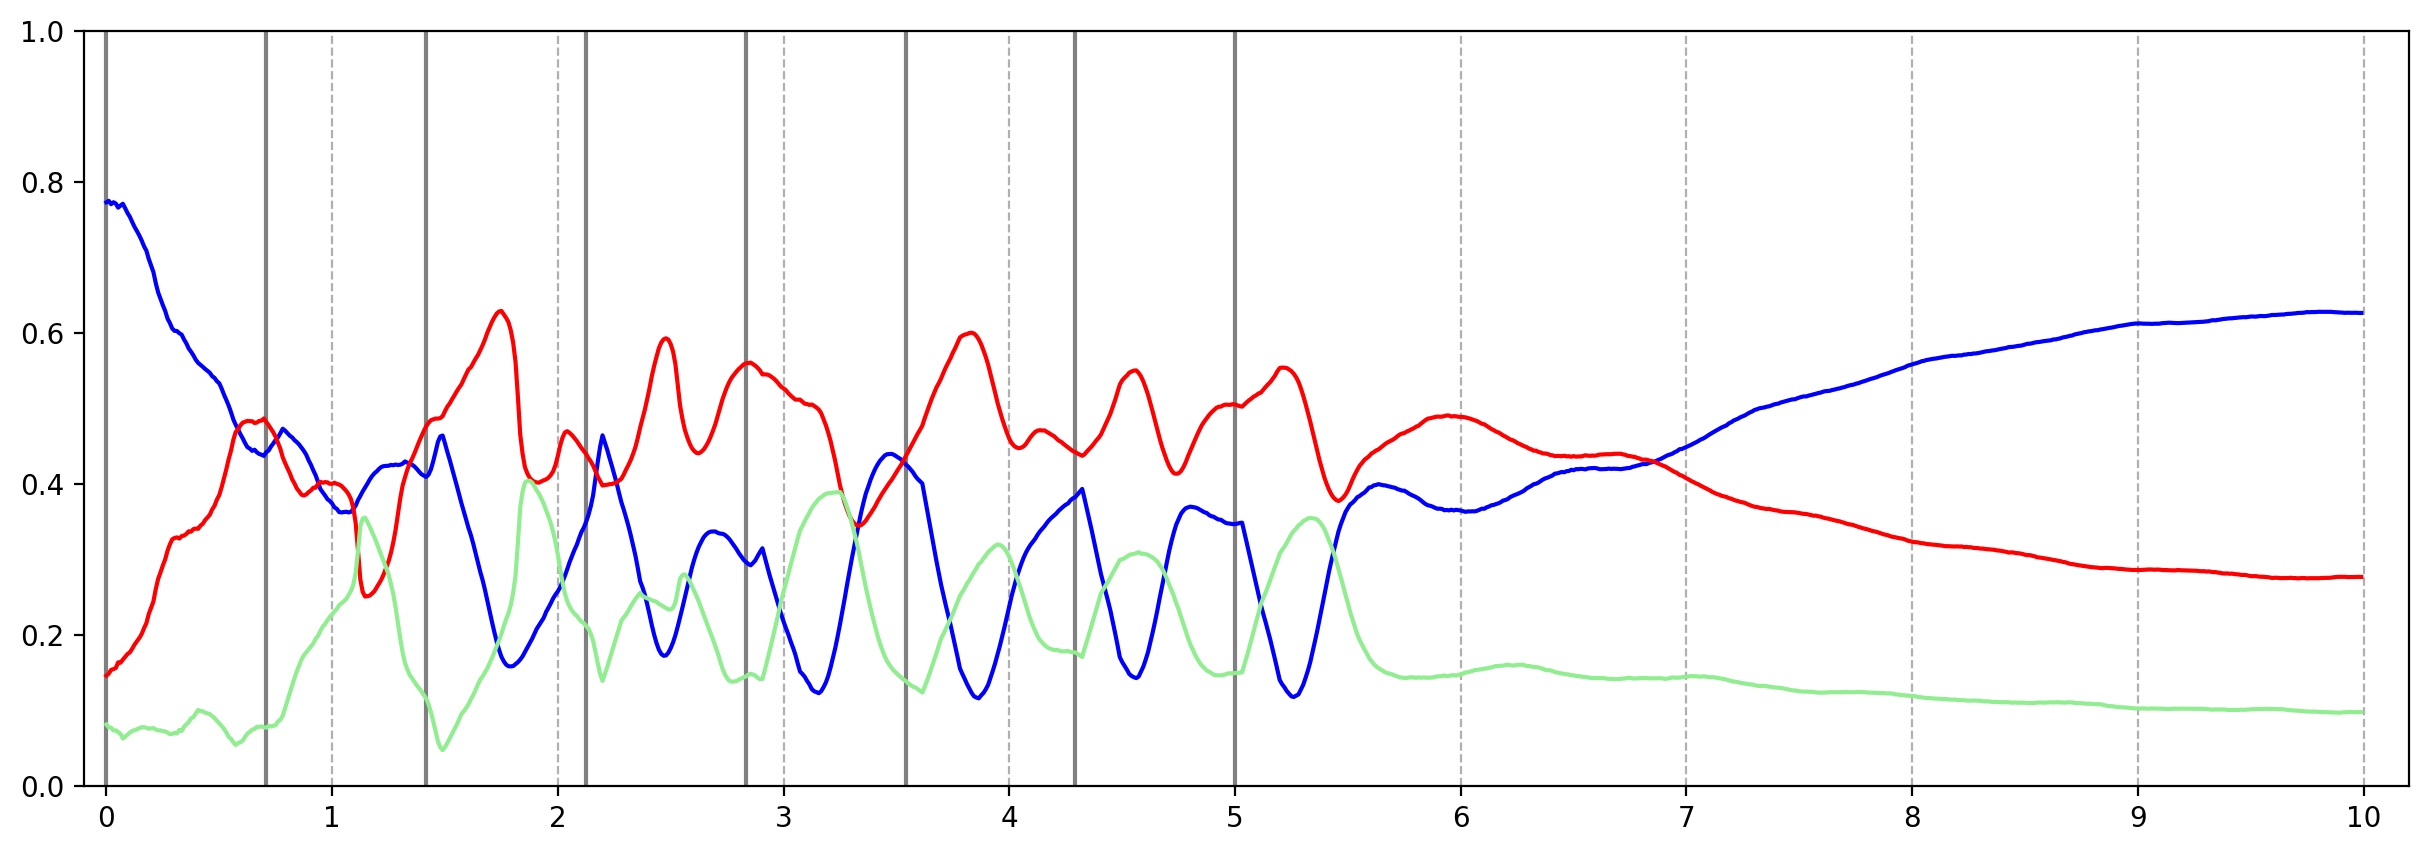

In [7]:
plot_cycle_phases(ref_b1_m_t['G1'], ref_b1_m_t['S'], ref_b1_m_t['G2M'], b1_times)

### GPU 

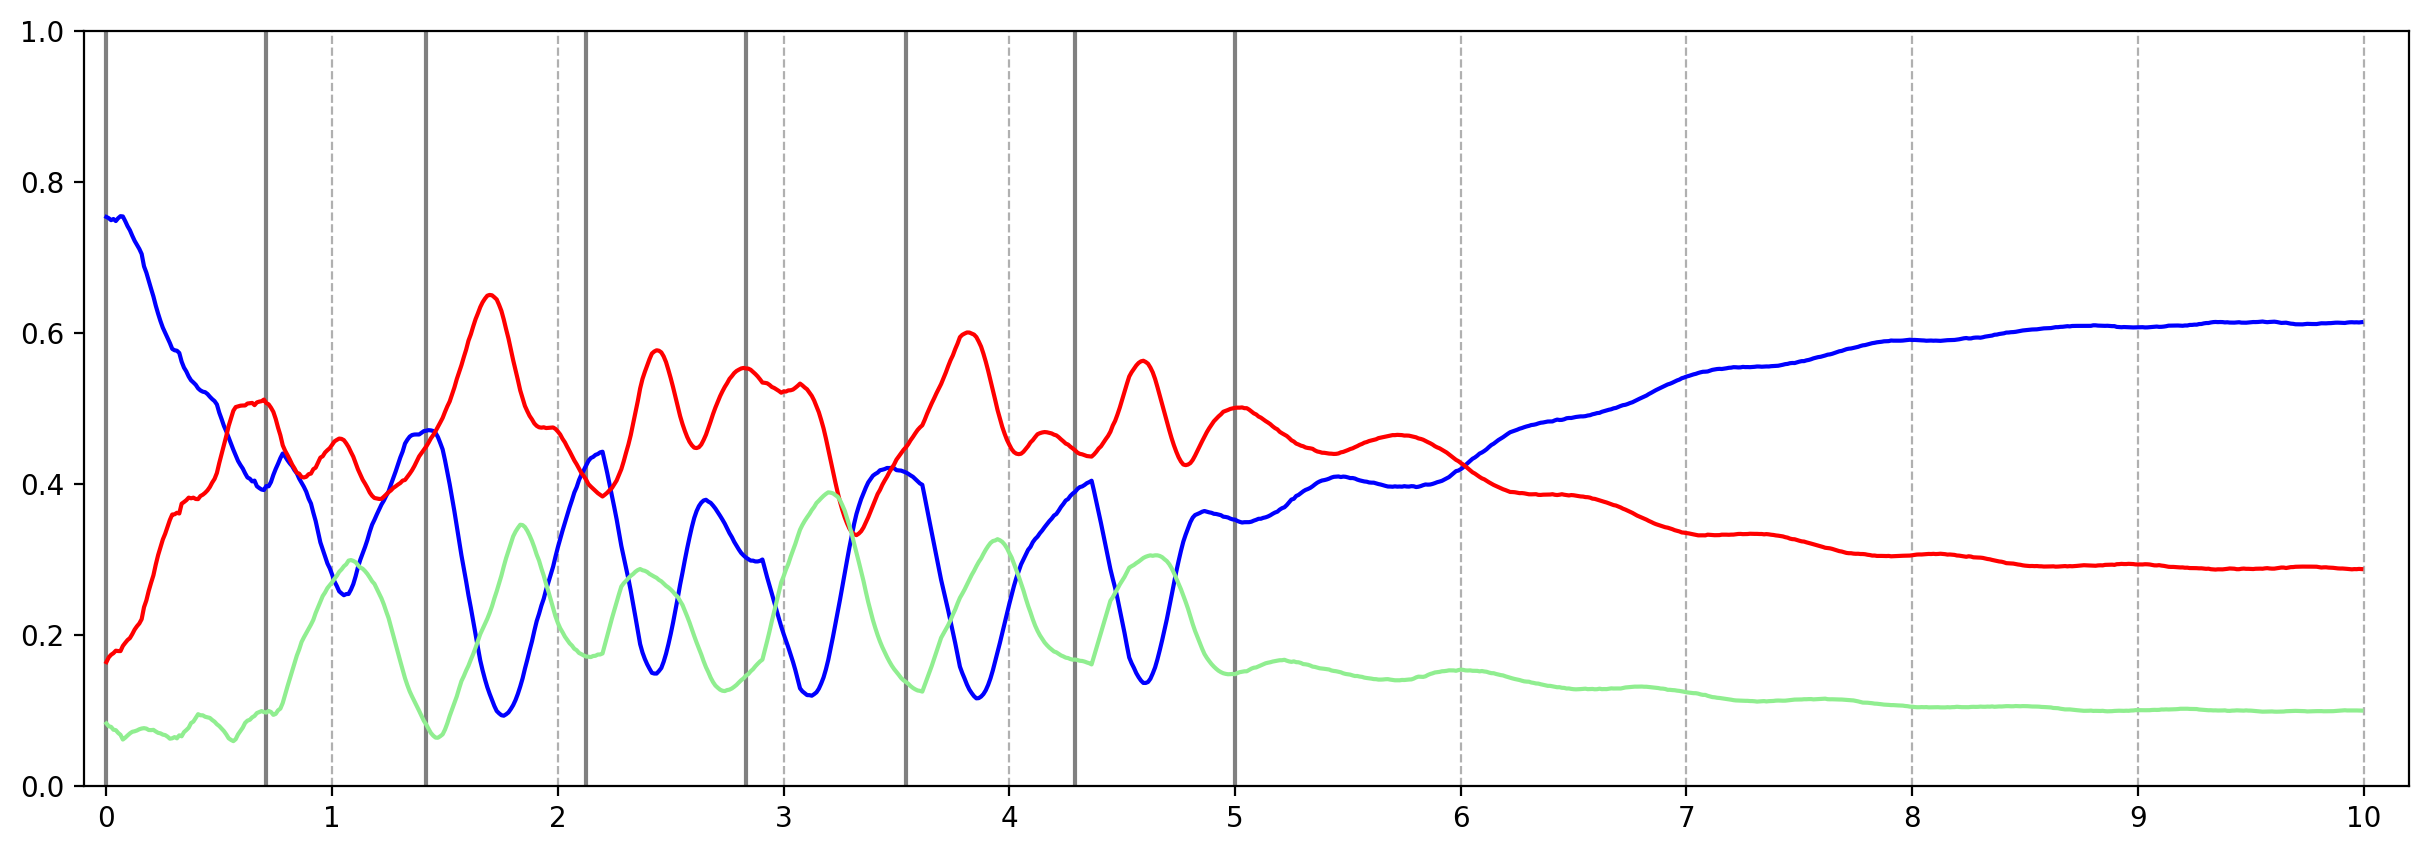

In [8]:
plot_cycle_phases(gpu_b1_m_t['G1'], gpu_b1_m_t['S'], gpu_b1_m_t['G2M'], b1_times)

### Mean squared error

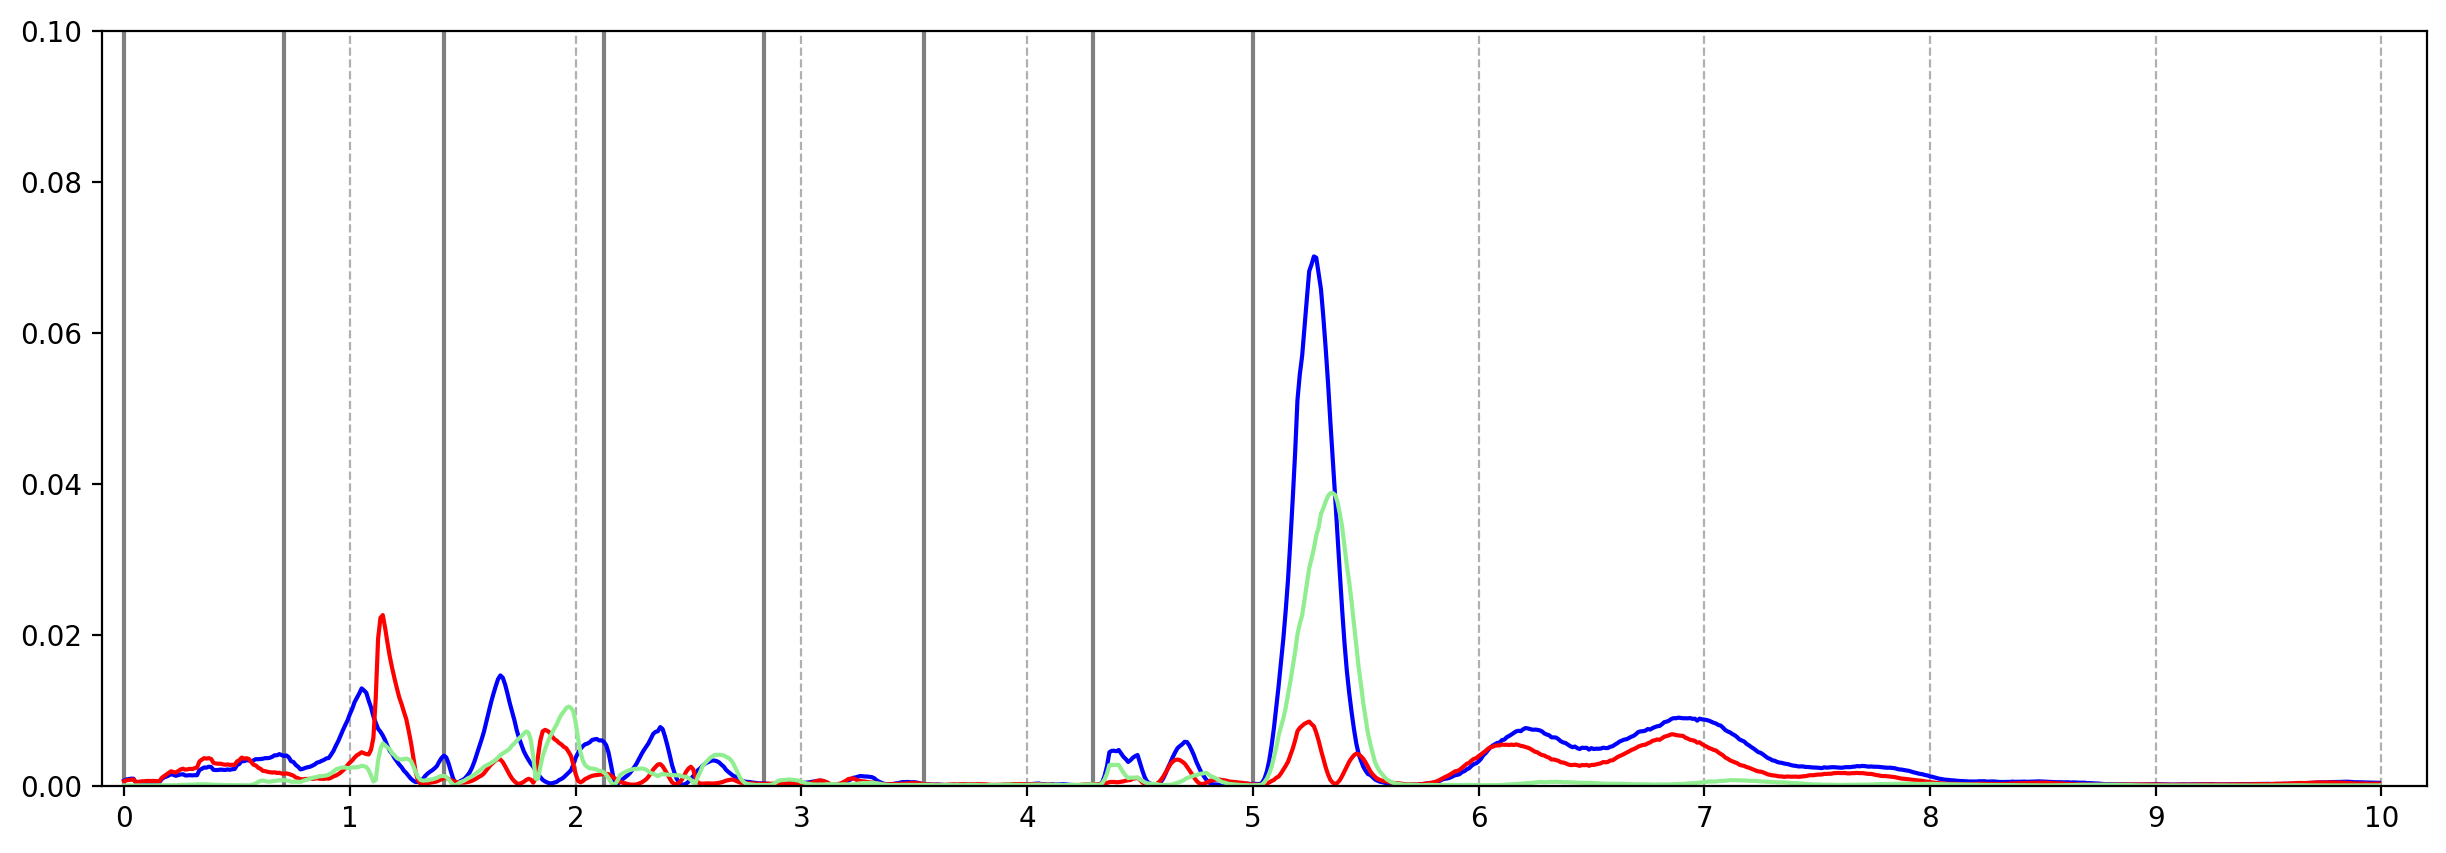

In [9]:
g1_se = (gpu_b1_m['G1'] - ref_b1_m['G1']) ** 2
s_se = (gpu_b1_m['S'] - ref_b1_m['S']) ** 2
g2m_se = (gpu_b1_m['G2M'] - ref_b1_m['G2M']) ** 2
# mean squared error across 10 tumors
plot_cycle_phases(np.mean(g1_se, 0), np.mean(s_se, 0), np.mean(g2m_se, 0), b1_times, (0, 0.1))

## Benchmark 2
### Reference 

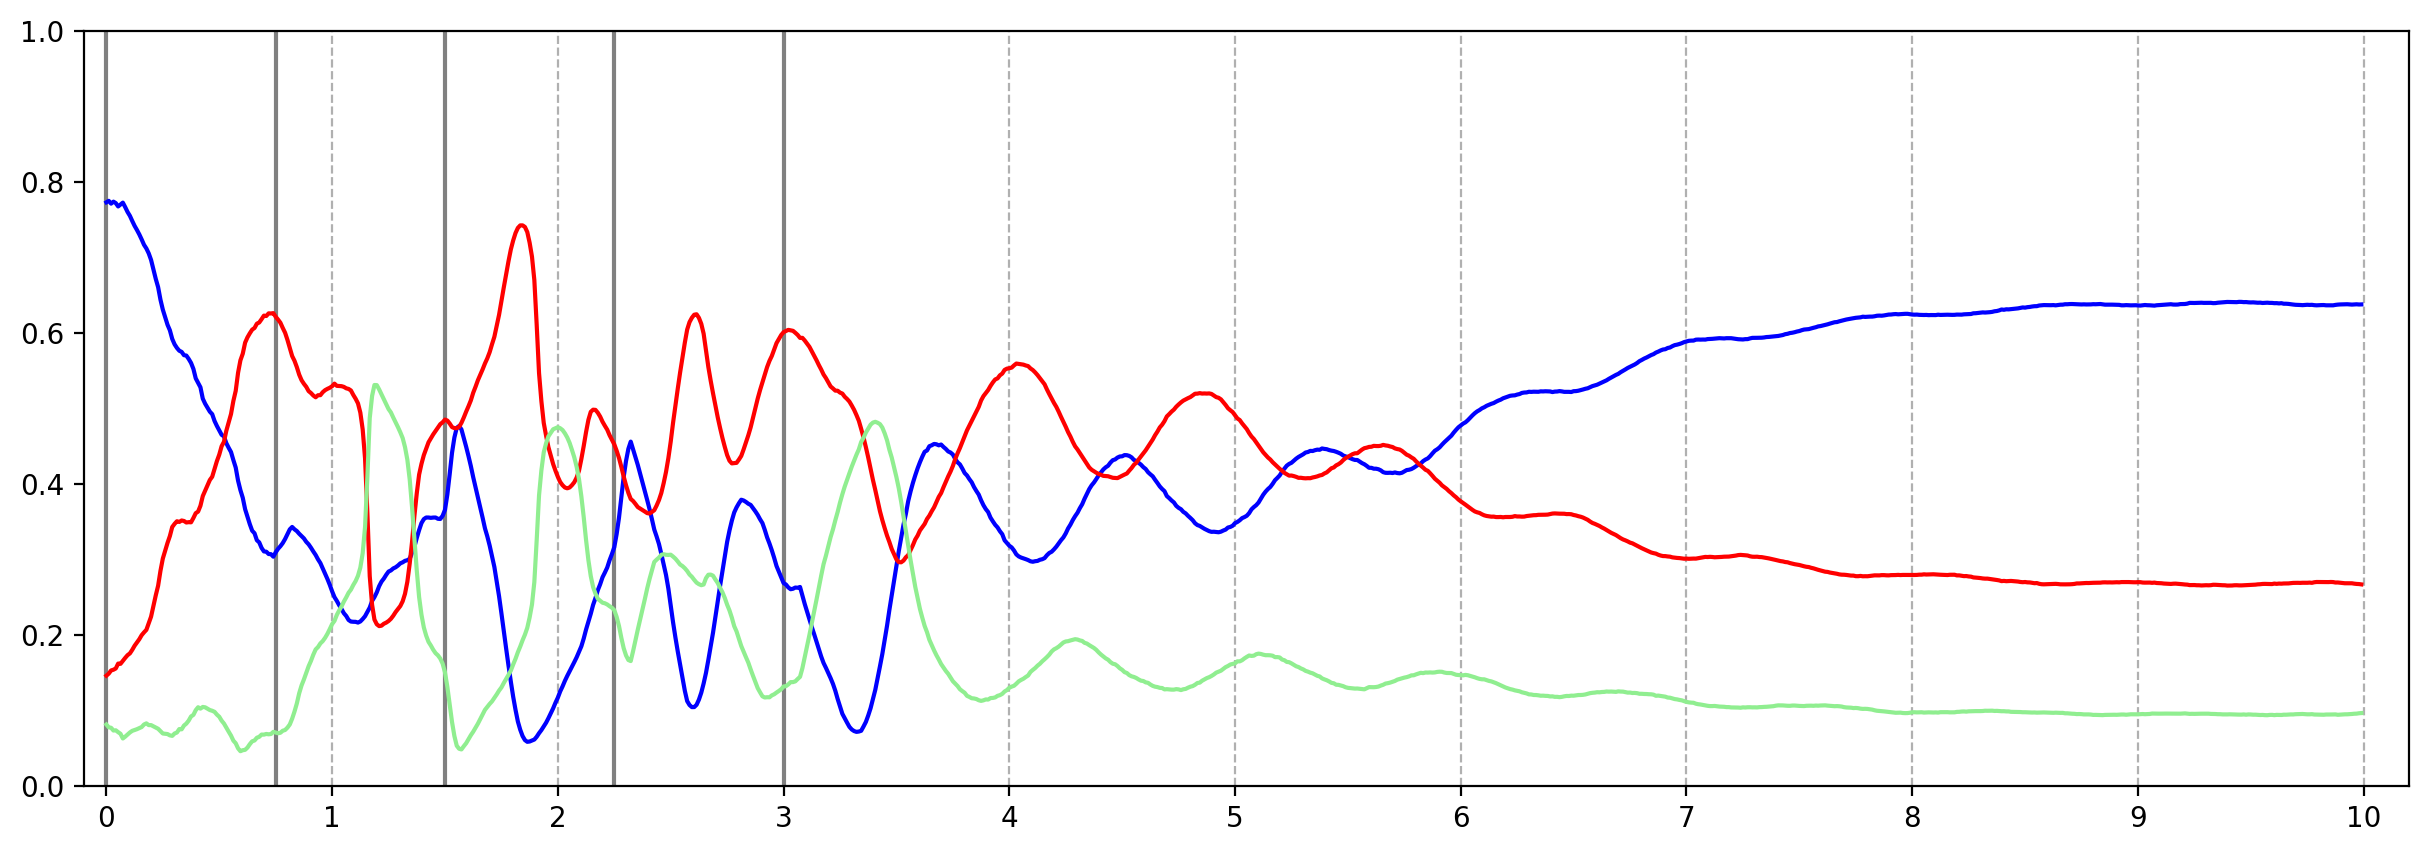

In [10]:
plot_cycle_phases(ref_b2_m_t['G1'], ref_b2_m_t['S'], ref_b2_m_t['G2M'], b2_times)

### GPU 

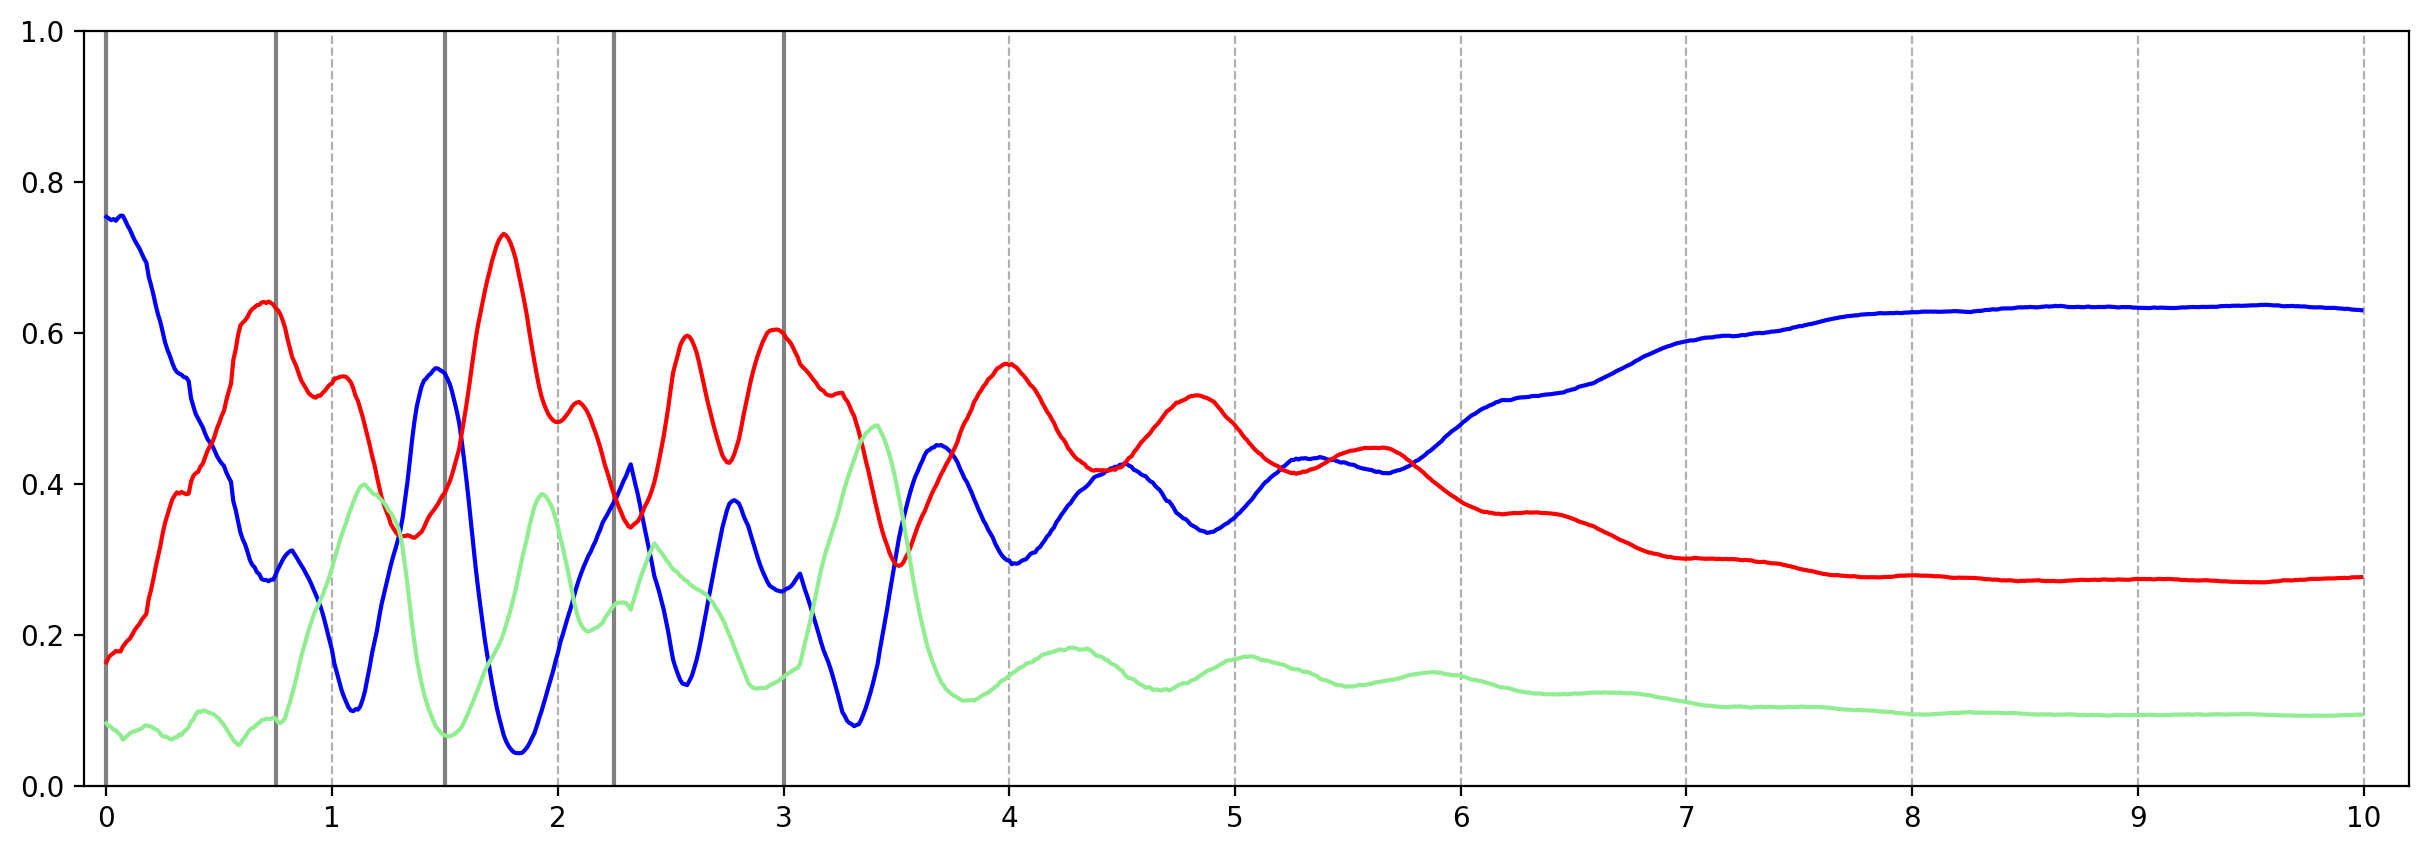

In [11]:
plot_cycle_phases(gpu_b2_m_t['G1'], gpu_b2_m_t['S'], gpu_b2_m_t['G2M'], b2_times)

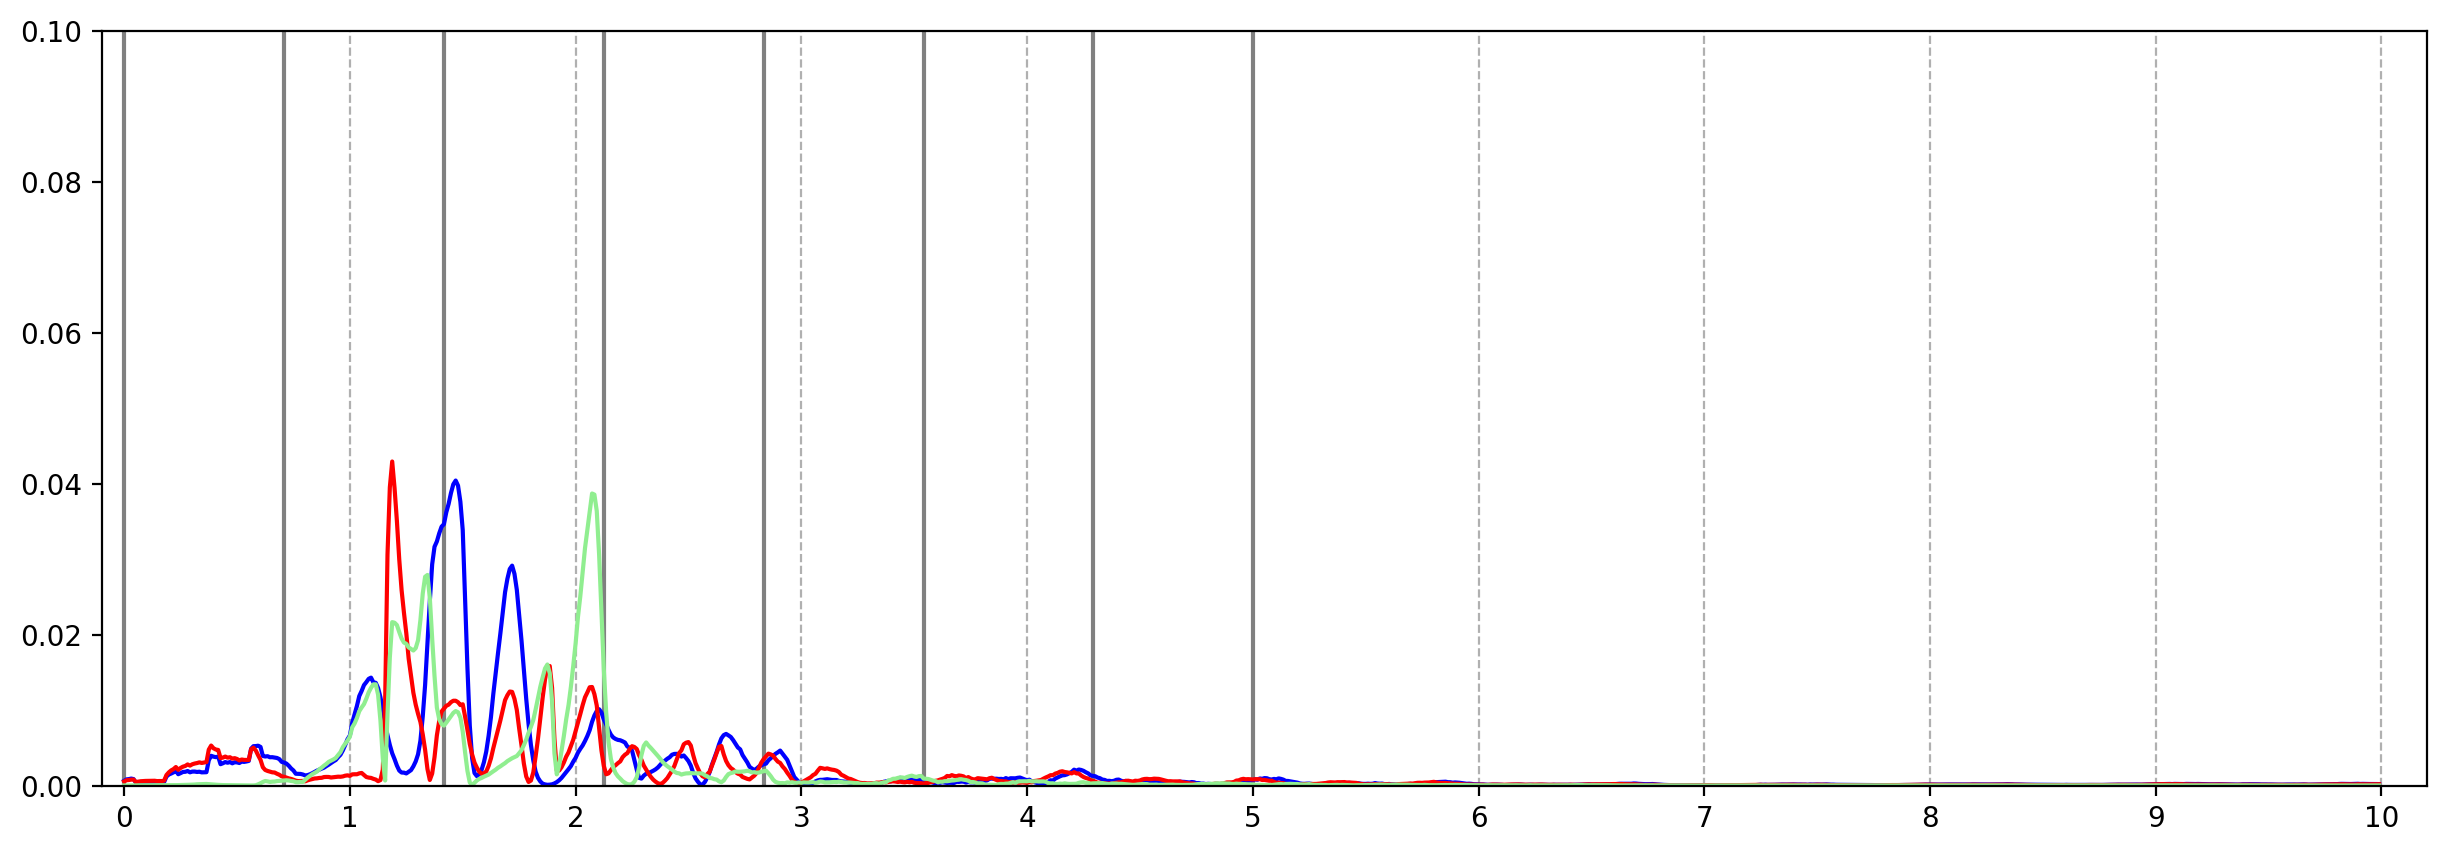

In [12]:
g1_se = (gpu_b2_m['G1'] - ref_b2_m['G1']) ** 2
s_se = (gpu_b2_m['S'] - ref_b2_m['S']) ** 2
g2m_se = (gpu_b2_m['G2M'] - ref_b2_m['G2M']) ** 2
# mean squared error across 10 tumors
plot_cycle_phases(np.mean(g1_se, 0), np.mean(s_se, 0), np.mean(g2m_se, 0), b1_times, (0, 0.1))

# Total number of cells

In [13]:
def plot_cells_count(lines, irradiations, colors=[], ylim=(0, 400)):
    figure(num=None, figsize=(15, 5), dpi=200, facecolor='w', edgecolor='k')
    plt.xticks(np.arange(0, 10.5, 1))
    plt.ylim(*ylim)
    plt.xlim(-0.1, 10.2)
    plt.grid(axis='x', linestyle='--')
    for time in irradiations:
        plt.axvline(time, color='gray')
    if len(colors) > 0:
        assert len(colors) == len(lines)
    for i in range(len(lines)):
        if len(colors) > 0:
            plt.plot(np.arange(0, 10, 1/96), lines[i], color=colors[i])
        else:
            plt.plot(np.arange(0, 10, 1/96), lines[i])

## Benchmark 1
### Cells count

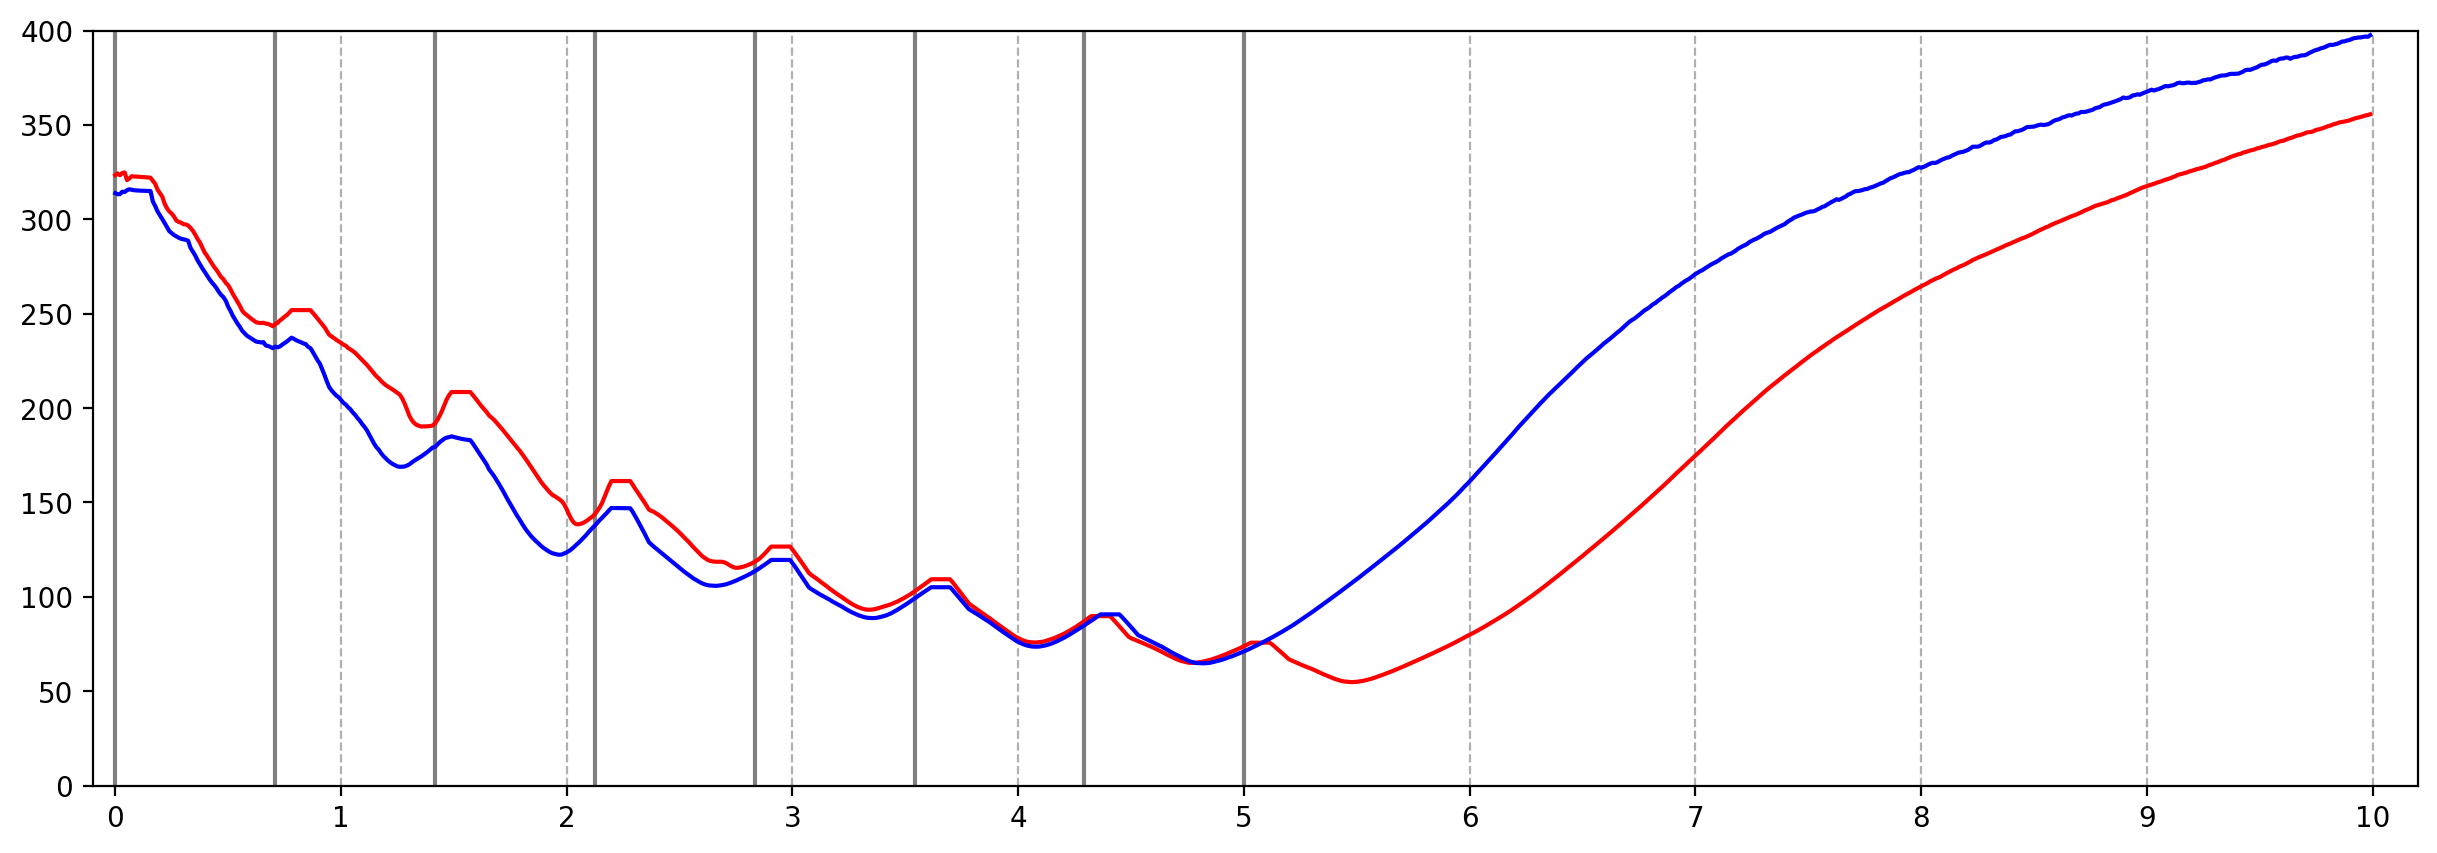

In [14]:
plot_cells_count([ref_b1_m_t['total_cells'], gpu_b1_m_t['total_cells']], b1_times, colors=['red', 'blue'])
# reference - red
# gpu - blue

### Mean squared relative error

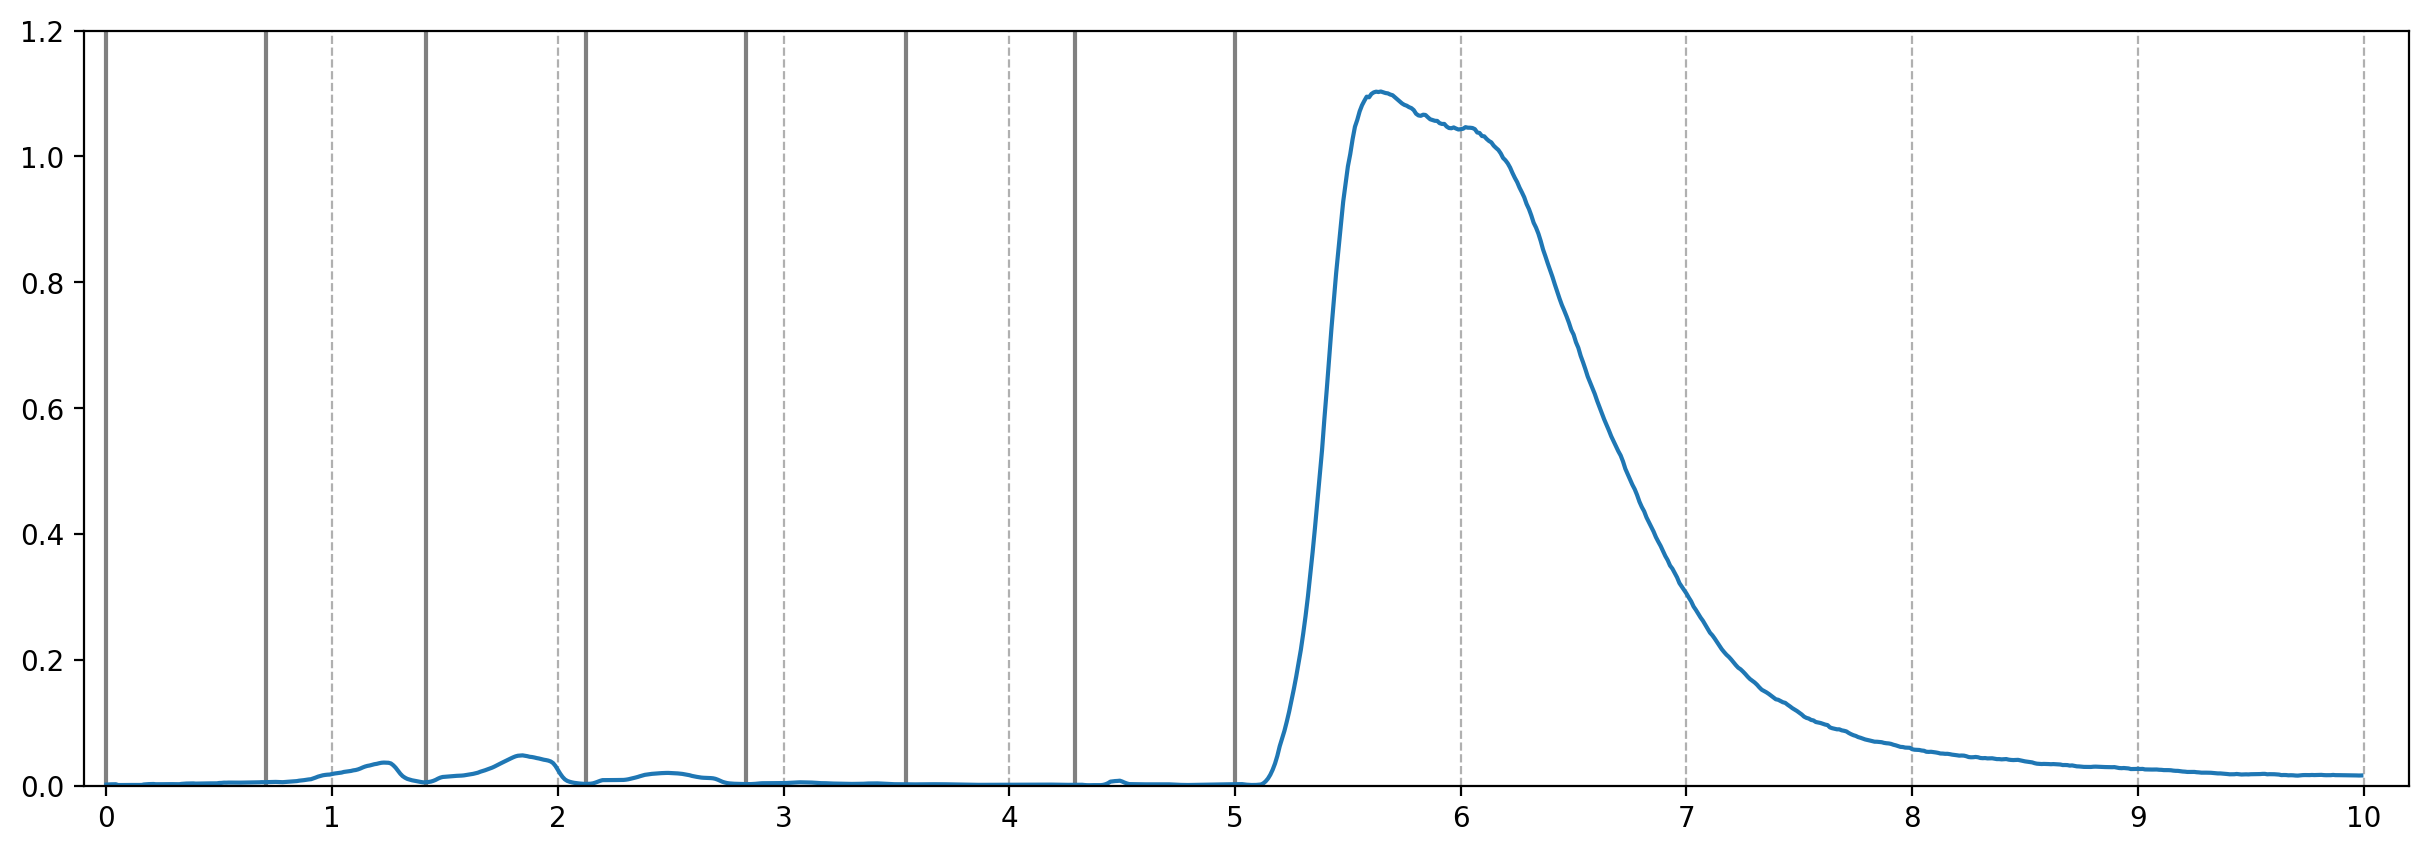

In [15]:
sre = ((ref_b1_m['total_cells'] - gpu_b1_m['total_cells']) / ref_b1_m['total_cells']) ** 2
plot_cells_count([np.mean(sre, 0)], b1_times, ylim=(0, 1.2))

## Benchmark 2
### Cells count

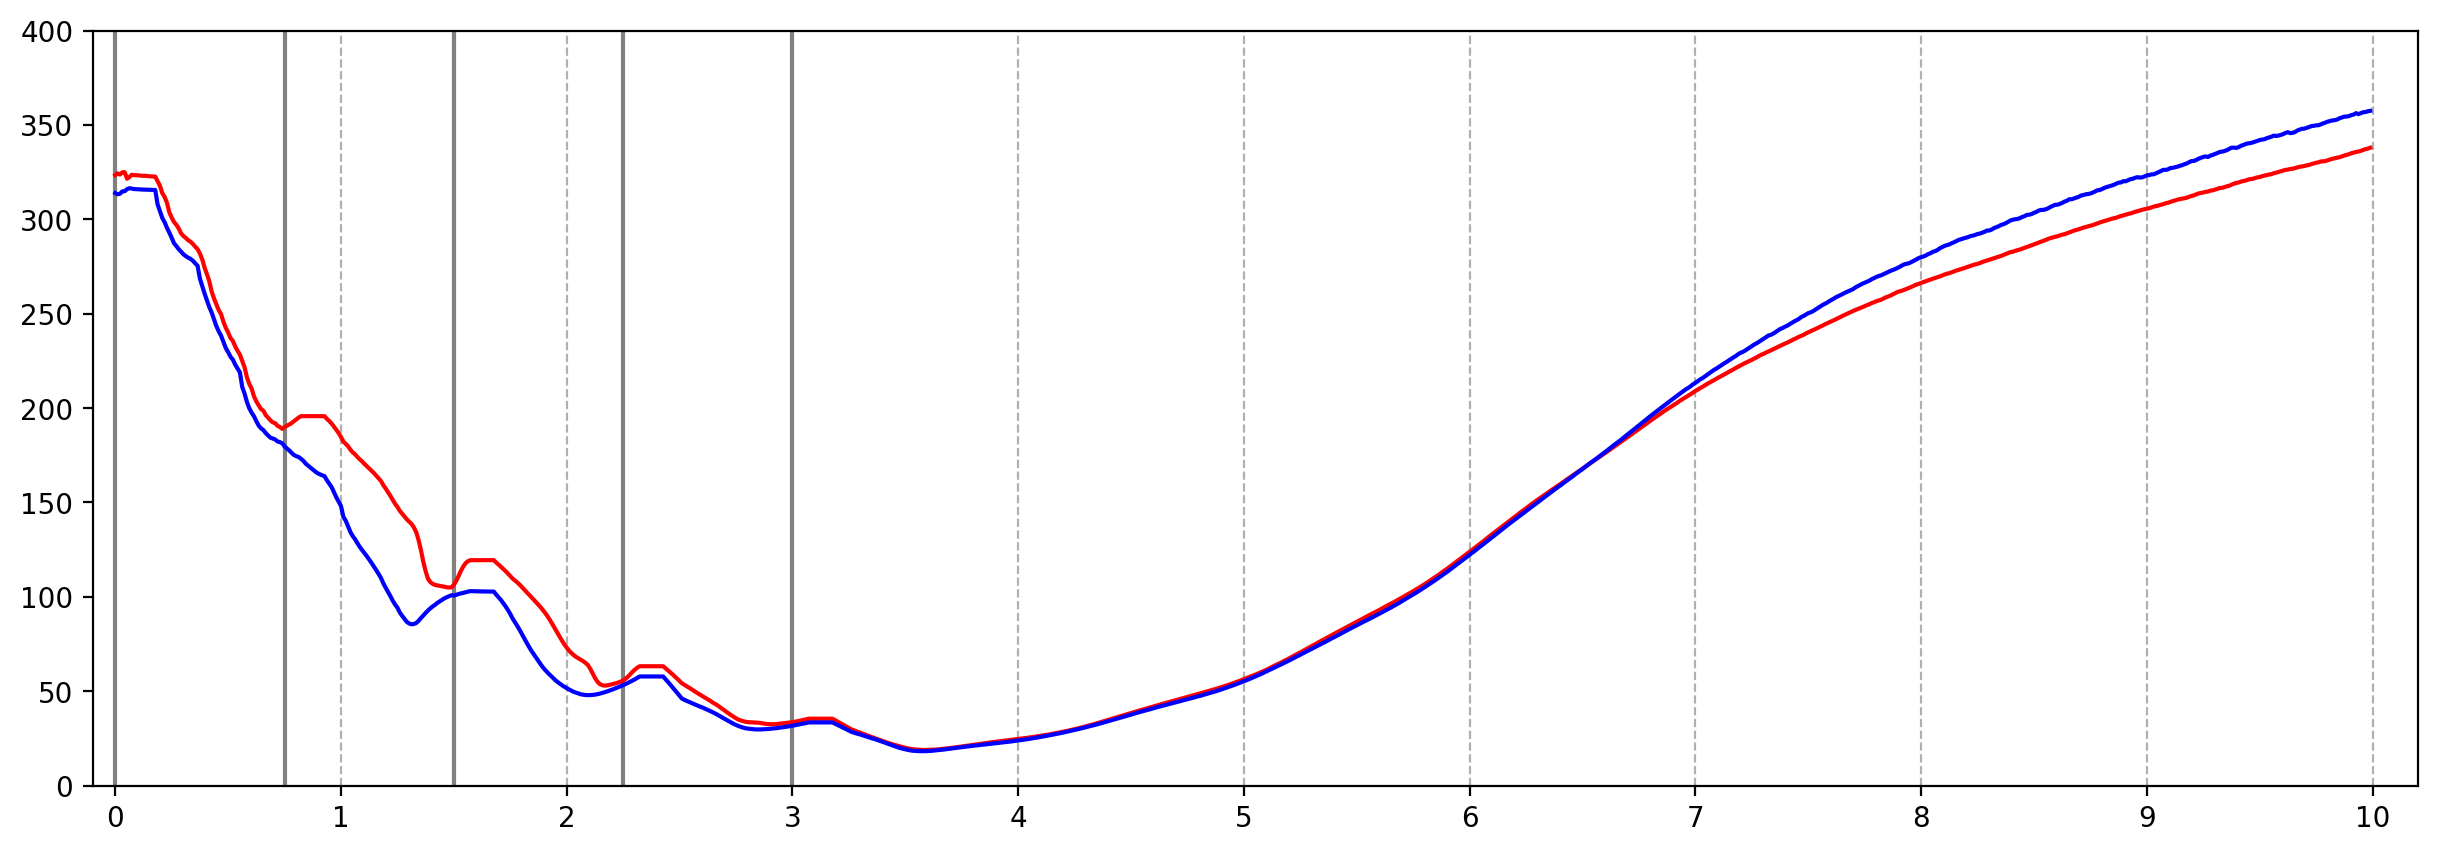

In [16]:
plot_cells_count([ref_b2_m_t['total_cells'], gpu_b2_m_t['total_cells']], b2_times, colors=['red', 'blue'])

### Mean squared relative error

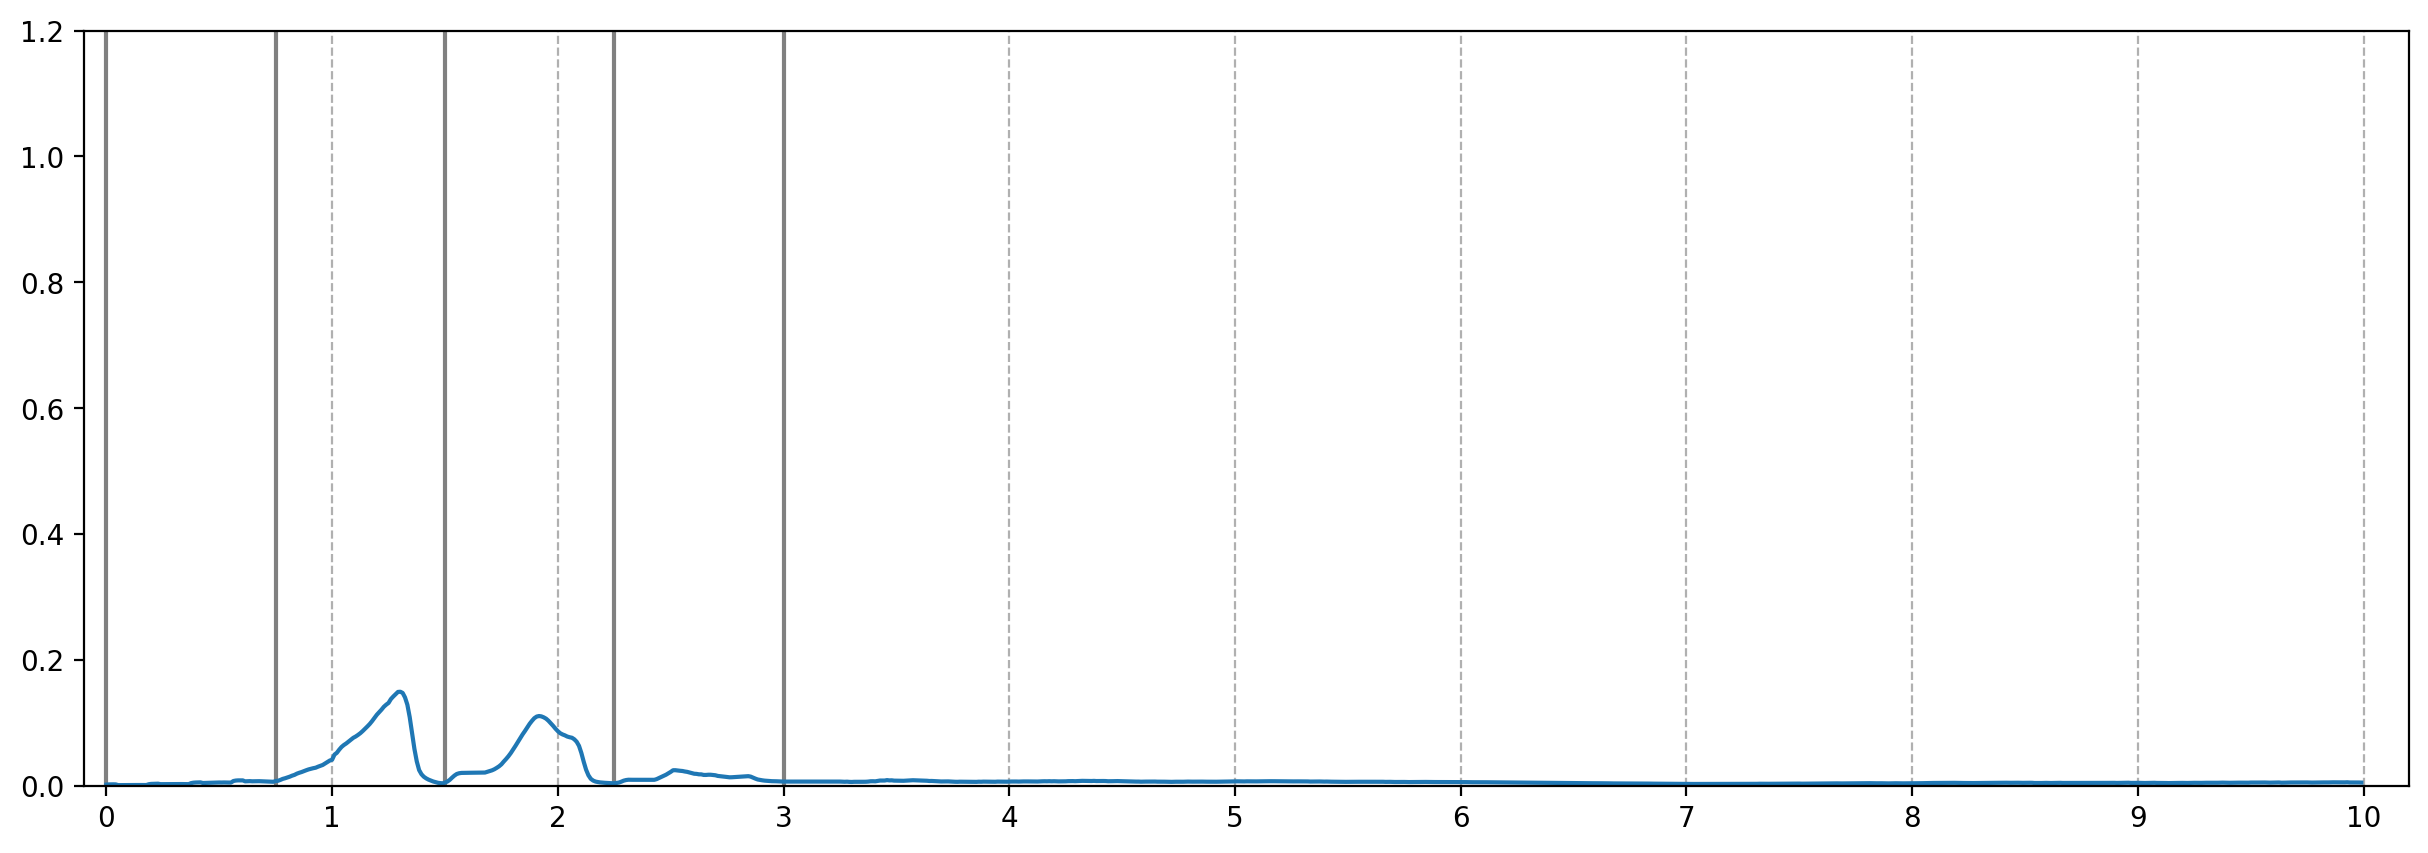

In [17]:
sre = ((ref_b2_m['total_cells'] - gpu_b2_m['total_cells']) / ref_b2_m['total_cells']) ** 2
plot_cells_count([np.mean(sre, 0)], b2_times, ylim=(0, 1.2))